# 1. Business Understanding

Dataset represents the transactions of several users of a music streaming company. Each row in the datase represent an action by a user on the platform. It gives various informations like name of the user, UserId, where did the user click in the page or song played.

Some of these users will eventually cancel their subscription. The aim of this project is predict who is going to churn before it happen


In [1]:
# import libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from pyspark.ml.feature import OneHotEncoderEstimator,StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import PolynomialExpansion
import pyspark.ml.evaluation as evals
import pyspark.ml.tuning as tune
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.feature import StandardScaler

In [2]:
# create a Spark session

spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

print(spark.version)

2.4.3


In [3]:
# Read the Data

path="mini_sparkify_event_data.json"
spotify=spark.read.json(path)

In [4]:
 for col in spotify.columns:
        print(col)

artist
auth
firstName
gender
itemInSession
lastName
length
level
location
method
page
registration
sessionId
song
status
ts
userAgent
userId


# 2. Data Understanding

In [5]:
print("Total number of rows are :",spotify.count())
print("\nColumns and number of unique values in each column are :\n")
for col in spotify.columns:
    print(col,spotify.select(col).distinct().count())

Total number of rows are : 286500

Columns and number of unique values in each column are :

artist 17656
auth 4
firstName 190
gender 3
itemInSession 1322
lastName 174
length 14866
level 2
location 115
method 2
page 22
registration 226
sessionId 2354
song 58481
status 3
ts 277447
userAgent 57
userId 226


Let's explore some of the colums with  small number of unique values like auth,gender,level

In [6]:
spotify.select('auth').groupBy('auth').count().show()

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+



In [7]:
spotify.select('gender').groupBy('gender').count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|  null|  8346|
|     M|123576|
+------+------+



In [8]:
spotify.select('level').groupBy('level').count().show()

+-----+------+
|level| count|
+-----+------+
| free| 58338|
| paid|228162|
+-----+------+



In [9]:
spotify.select('page').groupBy('page').count().orderBy('count',ascending=False).show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|                Home| 14457|
|           Thumbs Up| 12551|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|               Login|  3241|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|                Help|  1726|
|            Settings|  1514|
|               About|   924|
|             Upgrade|   499|
|       Save Settings|   310|
|               Error|   258|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+
only showing top 20 rows



In [10]:
spotify.createOrReplaceTempView("spotify")

### Define churned users

I need to define the churn first: There are two possibiliites

A paid customer cancelled and
A paid customer changes to free

Cancelled Customers have 'Cancellation Confirmation' on the page column

In [11]:
query=""" 
select userId,page
from spotify
where page='Cancellation Confirmation'
"""
spark.sql(query).show(5)

query=""" 
select count(distinct userId) Number_of_churned_users
from spotify
where page='Cancellation Confirmation'
"""
spark.sql(query).show(5)

+------+--------------------+
|userId|                page|
+------+--------------------+
|    18|Cancellation Conf...|
|    32|Cancellation Conf...|
|   125|Cancellation Conf...|
|   105|Cancellation Conf...|
|    17|Cancellation Conf...|
+------+--------------------+
only showing top 5 rows

+-----------------------+
|Number_of_churned_users|
+-----------------------+
|                     52|
+-----------------------+



Let's look at the cancelled users in detail !

In [12]:
query=""" 
Select level,auth,count(*) count
from spotify
where page='Cancellation Confirmation'
group by level,auth
"""
spark.sql(query).show()

+-----+---------+-----+
|level|     auth|count|
+-----+---------+-----+
| paid|Cancelled|   31|
| free|Cancelled|   21|
+-----+---------+-----+



So Cancelled users are both in free and paid categories. Some of the cancelled in free category may be in the trial version and other may be paid category and later changed to free. So let's look at these free accounts

In [13]:
# Following query calculate the number of distinct levels free users were in. If the number is 1, they were
# free category. If 2, they were previsouly paid customers

query=""" 

select level_count,count(level_count) as users
from
(Select userId, count(distinct level) as level_count
from spotify
Where userId In
(Select userId
from spotify
where level='free' and auth='Cancelled')
group by userID
order by 2 desc) sub
group by level_count
"""
spark.sql(query).show()

+-----------+-----+
|level_count|users|
+-----------+-----+
|          2|    5|
|          1|   16|
+-----------+-----+



So 16 out 21 free users who cancelled were always free users. For simplicity, I will avoid all users who are free when they cancelled

In [14]:
# Find the 5  free users who were cancelled and who were once paid

query=""" 
select userId
from
(Select userId, count(distinct level) as level_count
from spotify
Where userId In
(Select userId
from spotify
where level='free' and auth='Cancelled')
group by userID
order by 2 desc) sub
where level_count=2
group by userId
"""
spark.sql(query).show()

+------+
|userId|
+------+
|100025|
|100009|
|100012|
|200020|
|200011|
+------+



Let's look at the users who changed from paid to free

In [15]:
# This query add a new column to each row where new column (lead_level) is level of the next entry for each user
# For the users who churned from paid to free, level == 'paid' and level_level=='free'

query=""" 
select userId,page,level,lead_level
from
(select userId,page,level,lead(level) over (partition by userId order by ts) as lead_level
from spotify
where userId !=''
order by userId) sub
where level='paid' and lead_level='free'
"""
spark.sql(query).show(5)

+------+----------------+-----+----------+
|userId|            page|level|lead_level|
+------+----------------+-----+----------+
|   100|Submit Downgrade| paid|      free|
|100004|Submit Downgrade| paid|      free|
|100004|Submit Downgrade| paid|      free|
|100008|Submit Downgrade| paid|      free|
|100009|Submit Downgrade| paid|      free|
+------+----------------+-----+----------+
only showing top 5 rows



In [16]:
# This query will give the distinct users who changed from free to paid

query=""" 
select count(userId) userIds, count(distinct userId) distinct_userIds
from
(select userId,level,lead(level) over (partition by userId order by ts) as lead_level
from spotify
where userId !=''
order by userId) sub
where level='paid' and lead_level='free'
"""
spark.sql(query).show()

+-------+----------------+
|userIds|distinct_userIds|
+-------+----------------+
|     62|              49|
+-------+----------------+



Distinct userIds are smaller than userIds. This means some of the users might have gone back and forth between paid and free few times

In [17]:
# This query check whether the 5 user who changed from paid to free and then cancelled is in our current category

query=""" 
select userId
from 
(select userId
from
(select userId,level,lead(level) over (partition by userId order by ts) as lead_level
from spotify
where userId !=''
order by userId) sub
where level='paid' and lead_level='free' ) t1
where userId in (100025,100009,100012,200020,200011)
"""
spark.sql(query).show()

+------+
|userId|
+------+
|100009|
|100012|
|100025|
|200011|
|200020|
+------+



Yes ! They are all in the list of users who changed from free to paid

### Combine two types of churned users

In [18]:
query=""" 
select userID
from spotify
where page='Cancellation Confirmation' and level='paid' and userId !=''

Union

select distinct userId
from
(select userId,level,lead(level) over (partition by userId order by ts) as lead_level
from spotify
where userId !=''
order by userId) sub
where level='paid' and lead_level='free'

"""
churned_user_ids=spark.sql(query)
churned_user_ids.show(5)

+------+
|userID|
+------+
|    51|
|    54|
|100014|
|   101|
|    11|
+------+
only showing top 5 rows



In [19]:
churned_user_ids.count()

76

In [20]:
churned_user_ids.distinct().count()

76

In [21]:
churned_user_ids.createOrReplaceTempView('churned_user_ids')

# 3. Prepare Data

###  Data Cleaning

Free users might have some restrictions compared to paid users. Some of the free users might be trial users who has no intention to continue. So I will keep only paid users and aim is to predict who will churn based on their behaviour in paid accounts

In [22]:
# Let's look at the count based on different categories

query=""" 
select level,auth,count(*)count
from spotify
group by level,auth
"""
spark.sql(query).show()

+-----+----------+------+
|level|      auth| count|
+-----+----------+------+
| free|Logged Out|  2520|
| free|     Guest|    97|
| paid|Logged Out|  5729|
| paid| Cancelled|    31|
| free| Logged In| 55700|
| free| Cancelled|    21|
| paid| Logged In|222402|
+-----+----------+------+



In [23]:
# Confirm the entries in the paid and Loggged In categories
query=""" 
select count(*)
from spotify
where level='paid' and auth='Logged In'
"""
spark.sql(query).show()

+--------+
|count(1)|
+--------+
|  222402|
+--------+



In [24]:
# Create a temp table 

query=""" 
select *
from spotify
where level='paid' and auth='Logged In'
"""
temp=spark.sql(query)
temp.createOrReplaceTempView('temp')

In [25]:
# How many users have less than 25 entries
query=""" 
Select userId,count
from
(Select userId,count(*) count
from temp
group by userId) sub
where count<25
"""
spark.sql(query).show()

+------+-----+
|userId|count|
+------+-----+
|    26|    1|
+------+-----+



### Create the final cleaned dataset

In [26]:
query=""" 
select *
from spotify
where level='paid' and auth='Logged In' and userId not in (
Select userId
from
(Select userId,count(*) count
from temp
group by userId) sub
where count<25)
"""
spotify_cleaned=spark.sql(query)
spotify_cleaned.show(2)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|  Adam Lambert|Logged In|    Colin|     M|           51| Freeman| 282.8273| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Time For Miracles|   200|1538352394000

In [27]:
spotify_cleaned.count()

222401

In [28]:
# Let's check whether there are any null values in any column
for col in ['auth','level','sessionId','userId']:
    print(col)
    print(spotify_cleaned.filter(spotify_cleaned[col].isNull()).count())

auth
0
level
0
sessionId
0
userId
0


In [29]:
# Create a temporary table for the final cleaned dta
spotify_cleaned.createOrReplaceTempView('spotify_cleaned')

In [30]:
# Count the number of churned users in the data
query=""" 
select count(distinct userId) churned_users
from spotify_cleaned
where userId in (select * from churned_user_ids)

"""
spark.sql(query).show()

+-------------+
|churned_users|
+-------------+
|           76|
+-------------+



In [31]:
# Count the number of non-churned users in the data

query=""" 
select count(distinct userId) not_churned_users
from spotify_cleaned
where userId not in (select * from churned_user_ids)

"""
spark.sql(query).show()

+-----------------+
|not_churned_users|
+-----------------+
|               88|
+-----------------+



### Data Exploration and Feature Engineering

Now I can divide the dataset into two: one belonging to the churned users and other belonging to the non-churned users. Then I could compare various features between two groups and see whether they will help to distinguish two types of users

In [32]:
# Let's create two separate dataframe: One for churned and another for non-churned users

query=""" 
select *
from spotify_cleaned
where userId in (select * from churned_user_ids)

"""
spotify_churn=spark.sql(query)
spotify_churn.createOrReplaceTempView('spotify_churn')

query=""" 
select *
from spotify_cleaned
where userId not in (select * from churned_user_ids)
"""
spotify_no_churn=spark.sql(query)
spotify_no_churn.createOrReplaceTempView('spotify_no_churn')

### Define the churned users

In [33]:
query=""" 
Select distinct userId,Case When userID is not null then 1 End as Churn
from spotify_cleaned
Where userId in (select userId from churned_user_ids) 
Union 
Select distinct userId,Case When userID is not null then 0 End as Churn
from spotify_cleaned
Where userId not in (select userId from churned_user_ids) 
"""
user_churn=spark.sql(query)
user_churn.show(5)


+------+-----+
|userId|Churn|
+------+-----+
|    19|    0|
|300007|    1|
|200007|    0|
|    25|    1|
|    50|    0|
+------+-----+
only showing top 5 rows



In [34]:
user_churn.count()

164

### 1.skip_ratio

This is the number of times a user skipped a song before 120 seconds as a fraction of total number of entries for that user. My assumption is that if a user doesn't like the song, he will do this often

In [35]:
# skip_ratio for non-churned users

query=""" 
With t3 as
(With t1 as (
select userId userId1,count(*) cn1 from spotify_no_churn group by userId order by userId
),
 t2 as (
select userId userId2,count(*) cn2 from spotify_no_churn where length<120 group by userId order by userId
)
Select *
from t1
left Join t2
on t2.userId2=t1.userId1)
Select userId1 as userId,cn2/cn1 skip_ratio
from t3
order by skip_ratio desc

"""
user_skip_ratio_nc=spark.sql(query).toPandas()

In [36]:
# skip_ratio for Churned users

query=""" 
With t3 as
(With t1 as (
select userId userId1,count(*) cn1 from spotify_churn group by userId order by userId
),
 t2 as (
select userId userId2,count(*) cn2 from spotify_churn where length<120 group by userId order by userId
)
Select *
from t1
left Join t2
on t2.userId2=t1.userId1)
Select userId1 as userId,cn2/cn1 skip_ratio
from t3
order by skip_ratio desc

"""
user_skip_ratio_c=spark.sql(query).toPandas()

No handles with labels found to put in legend.


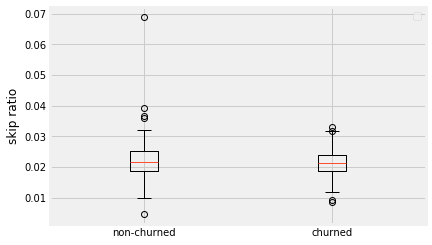

In [37]:
plt.boxplot([user_skip_ratio_nc['skip_ratio'].dropna(),user_skip_ratio_c['skip_ratio'].dropna()],labels=['non-churned', 'churned'])
plt.legend(loc='upper right')
plt.ylabel('skip ratio')
plt.show()

In [38]:
# Create dataframe with userId and skip ratio for all the dataset

query=""" 
With t3 as
(With t1 as (
select userId userId1,count(*) cn1 from spotify_cleaned group by userId order by userId
),
 t2 as (
select userId userId2,count(*) cn2 from spotify_cleaned where length<120 group by userId order by userId
)
Select *
from t1
left Join t2
on t2.userId2=t1.userId1)
Select userId1 as userId,cn2/cn1 skip_ratio
from t3
order by skip_ratio desc

"""
user_skip_ratio=spark.sql(query)
user_skip_ratio=user_skip_ratio.fillna(0)
user_skip_ratio.show(5)

+------+--------------------+
|userId|          skip_ratio|
+------+--------------------+
|    55| 0.06896551724137931|
|300005| 0.03939393939393939|
|    79|0.036585365853658534|
|    93| 0.03614457831325301|
|300004| 0.03289473684210526|
+------+--------------------+
only showing top 5 rows



In [39]:
user_skip_ratio.count()

164

### 2. Thumbs up/Thumbs down ratio

Ratio of Thumbs up to Thumbs down could be an indicator the user satisfaction

In [40]:
# Thumbs up/Thumbs down ratio for non-churned users

query=""" 
With t3 as
(With t1 as (
select userId userId1,count(*) t_up from spotify_no_churn Where page='Thumbs Up' group by userId order by userId
),
 t2 as (
select userId userId2,count(*) t_down from spotify_no_churn where page='Thumbs Down' group by userId order by userId
)
Select *
from t1
left Join t2
on t2.userId2=t1.userId1)
Select userId1 as userId,t_up/t_down updown_ratio
from t3
order by updown_ratio desc

"""
updown_ratio_nc=spark.sql(query).toPandas()

In [41]:
updown_ratio_nc.shape

(87, 2)

In [42]:
# Thumbs up/Thumbs down ratio for churned users
query=""" 
With t3 as
(With t1 as (
select userId userId1,count(*) t_up from spotify_churn Where page='Thumbs Up' group by userId order by userId
),
 t2 as (
select userId userId2,count(*) t_down from spotify_churn where page='Thumbs Down' group by userId order by userId
)
Select *
from t1
left Join t2
on t2.userId2=t1.userId1)
Select userId1 as userId,t_up/t_down updown_ratio
from t3
order by updown_ratio desc

"""
updown_ratio_c=spark.sql(query).toPandas()

In [43]:
updown_ratio_c.shape

(76, 2)

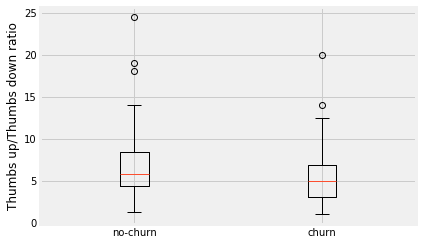

In [44]:
plt.boxplot([updown_ratio_nc['updown_ratio'].dropna(),updown_ratio_c['updown_ratio'].dropna()],labels=['no-churn','churn'])
plt.ylabel('Thumbs up/Thumbs down ratio')
plt.show()

In [45]:
# Create dataframe with userId and Thumbs up/Thumbs down ratio for all the dataset


query=""" 
With t3 as
(With t1 as (
select userId userId1,count(*) t_up from spotify_cleaned Where page='Thumbs Up' group by userId order by userId
),
 t2 as (
select userId userId2,count(*) t_down from spotify_cleaned where page='Thumbs Down' group by userId order by userId
)
Select *
from t1
left Join t2
on t2.userId2=t1.userId1)
Select userId1 as userId,t_up/t_down updown_ratio
from t3
order by updown_ratio desc

"""
user_updown_ratio=spark.sql(query)
user_updown_ratio=user_updown_ratio.fillna(0)
user_updown_ratio.show(5)

+------+------------+
|userId|updown_ratio|
+------+------------+
|   155|        24.5|
|    18|        20.0|
|300013|        19.0|
|300020|        18.0|
|100015|        14.0|
+------+------------+
only showing top 5 rows



In [46]:
user_updown_ratio.count()

163

###  3. Page counts

Other than Thumbs up / Thumbs down ratio,  categories in page column could be interesting as well

In [47]:
query=""" 

With t3 as (
With t1 as (
Select userId Id1,count(*) user_count
from spotify_no_churn group by userId),
t2 as
(Select userId Id2,page,count(*) page_count
from spotify_no_churn
group by userId,page)
Select *
from t1
join t2
on t2.Id2=t1.Id1)
Select Id1 as userId,page,page_count/user_count as page_count_frac
from t3
"""
user_page_nc=spark.sql(query)
user_page_nc=user_page_nc.groupBy('userId').pivot('page').sum('page_count_frac').toPandas()

In [48]:
query=""" 

With t3 as (
With t1 as (
Select userId Id1,count(*) user_count
from spotify_churn group by userId),
t2 as
(Select userId Id2,page,count(*) page_count
from spotify_churn
group by userId,page)
Select *
from t1
join t2
on t2.Id2=t1.Id1)
Select Id1 as userId,page,page_count/user_count as page_count_frac
from t3
"""
user_page_c=spark.sql(query)
user_page_c=user_page_c.groupBy('userId').pivot('page').sum('page_count_frac').toPandas()

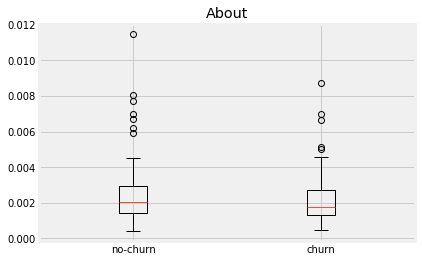

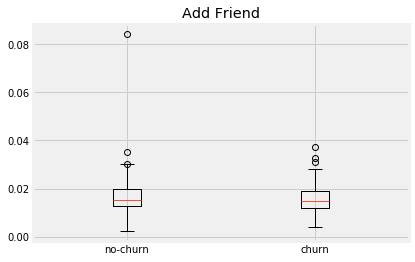

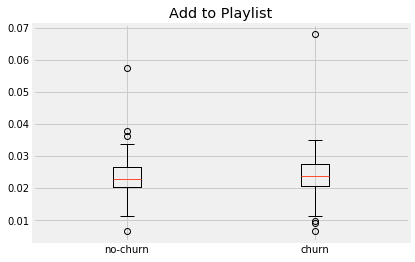

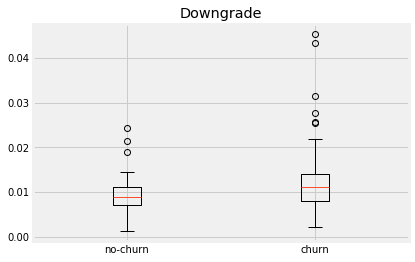

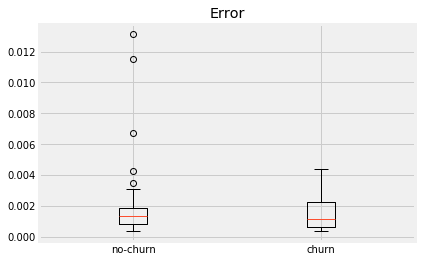

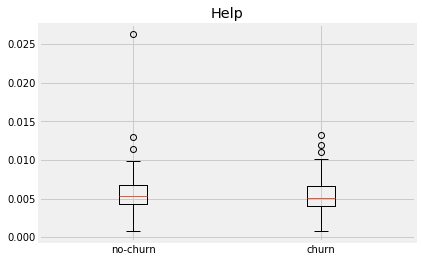

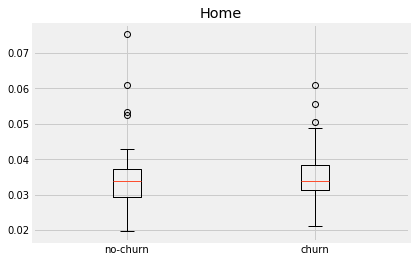

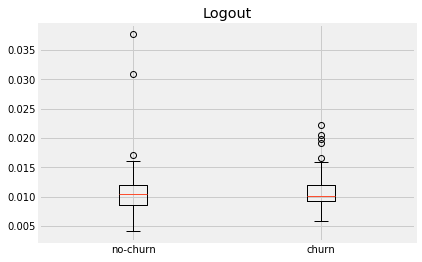

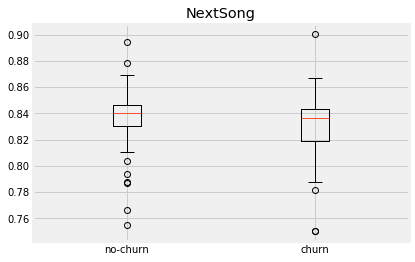

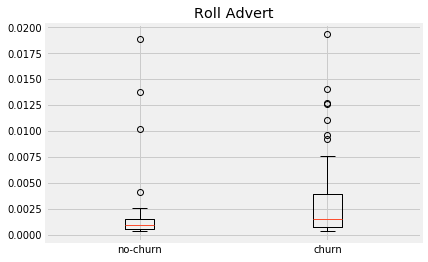

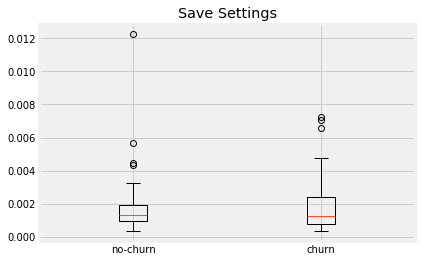

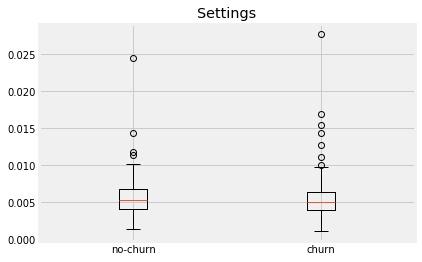

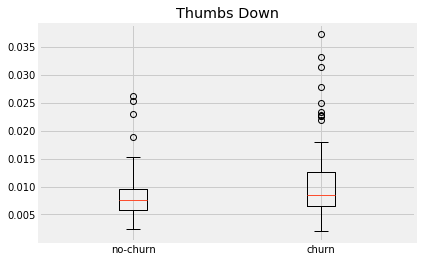

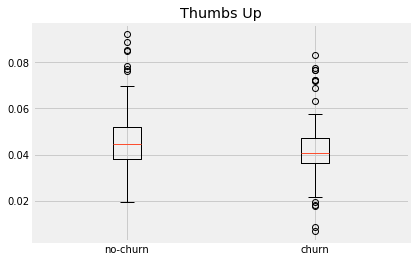

In [49]:
# Following plots describe the different categories of page for churned and non-churned users

for col in user_page_c.columns:
    if col in user_page_nc.columns:
        if col!='userId':
            plt.boxplot([user_page_nc[col].dropna(),user_page_c[col].dropna()],labels=['no-churn','churn'])
            plt.title(col)
            plt.show()
plt.show()

I have selected three pages categories : NextSong,Roll Advert and Error for further Analysis. Categories like Downgrade shouldn't be selected as they are directly correlated with cancellation

In [50]:
query=""" 

With t3 as (
With t1 as (
Select userId Id1,count(*) user_count
from spotify_cleaned group by userId),
t2 as
(Select userId Id2,page,count(*) page_count
from spotify_cleaned
group by userId,page)
Select *
from t1
join t2
on t2.Id2=t1.Id1)
Select Id1 as userId,page,page_count/user_count as page_count_frac
from t3
"""
user_page_count=spark.sql(query)
user_page_count=user_page_count.groupBy('userId').pivot('page').sum('page_count_frac')
user_page_count=user_page_count.select(['userId','Error','NextSong','Roll Advert'])
user_page_count=user_page_count.fillna(0)
user_page_count.show(5)

+------+--------------------+------------------+--------------------+
|userId|               Error|          NextSong|         Roll Advert|
+------+--------------------+------------------+--------------------+
|200002|                 0.0| 0.847457627118644|                 0.0|
|    51|4.060089321965083E-4| 0.857084855866829|                 0.0|
|   124|0.001243523316062176|0.8453886010362694|8.290155440414508E-4|
|    54|3.498950314905528E-4|0.8404478656403079|0.001049685094471...|
|    15| 8.77963125548727E-4|0.8402107111501317|4.389815627743635E-4|
+------+--------------------+------------------+--------------------+
only showing top 5 rows



In [51]:
user_page_count.count()

164

###  4.Top 10 artist fraction

I believe that dedicated music fans have favourite artists. And the presence of songs of their favourite artist's is something that make customers happy. So I calculated the total entries of top 10 artists for each user and divided by the total of entries for the same user

In [52]:
# top 10 artist fraction for non-churned users
query=""" 

With final_table as
(With t1 as (
Select userId Id1,count(*) total_count
from spotify_no_churn group by userId
),
t2 as (

Select userId Id2,sum(cn) sum_top3
from
(select * from
(select userId,artist,cn,
row_number() over(Partition by userId order by cn desc) as row_num
from
(Select userId,artist,count(artist) as cn
from spotify_no_churn
group by userId,artist
order by artist,cn desc) sub
order by userId) table2
where row_num<=10
order by userId,row_num)t3
group by userId )

Select *
from t1
join t2
on t2.Id2=t1.Id1)

Select Id1,sum_top3/total_count top10_frac
from final_table
order by top10_frac desc

"""
top10_nc=spark.sql(query).toPandas()

In [53]:
# top 10 artist fraction for churned users

query=""" 

With final_table as
(With t1 as (
Select userId Id1,count(*) total_count
from spotify_churn group by userId
),
t2 as (

Select userId Id2,sum(cn) sum_top3
from
(select * from
(select userId,artist,cn,
row_number() over(Partition by userId order by cn desc) as row_num
from
(Select userId,artist,count(artist) as cn
from spotify_churn
group by userId,artist
order by artist,cn desc) sub
order by userId) table2
where row_num<=10
order by userId,row_num)t3
group by userId )

Select *
from t1
join t2
on t2.Id2=t1.Id1)

Select Id1,sum_top3/total_count top10_frac
from final_table
order by top10_frac desc

"""
top10_c=spark.sql(query).toPandas()

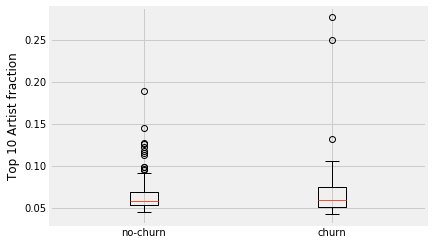

In [54]:
plt.boxplot([top10_nc['top10_frac'].dropna(),top10_c['top10_frac'].dropna()],labels=['no-churn','churn'])
plt.ylabel('Top 10 Artist fraction')
plt.show()

In [55]:
# Create dataframe with userId and Thumbs up/Thumbs down ratio for all the dataset

query=""" 

With final_table as
(With t1 as (
Select userId Id1,count(*) total_count
from spotify_cleaned group by userId
),
t2 as (

Select userId Id2,sum(cn) sum_top3
from
(select * from
(select userId,artist,cn,
row_number() over(Partition by userId order by cn desc) as row_num
from
(Select userId,artist,count(artist) as cn
from spotify_cleaned
group by userId,artist
order by artist,cn desc) sub
order by userId) table2
where row_num<=10
order by userId,row_num)t3
group by userId )

Select *
from t1
join t2
on t2.Id2=t1.Id1)

Select Id1 as userId,sum_top3/total_count top10_frac
from final_table
order by top10_frac desc

"""
user_top10_artist_frac=spark.sql(query)
user_top10_artist_frac=user_top10_artist_frac.fillna(0)
user_top10_artist_frac.show(5)

+------+-------------------+
|userId|         top10_frac|
+------+-------------------+
|   122| 0.2777777777777778|
|    32|               0.25|
|   137|0.18867924528301888|
|200007|0.14473684210526316|
|300004|0.13157894736842105|
+------+-------------------+
only showing top 5 rows



In [56]:
user_top10_artist_frac.count()

164

###  5. Distinct artist & songs fraction

This calculate the number of distinct artists and songs a user has visited as a fraction of total counts

In [57]:
query=""" 
Select userId,count( distinct artist)/count(*) distinct_artists ,count( distinct song)/count(*) distinct_songs
from spotify_no_churn
group by userId
order by distinct_artists
"""
artist_song_nc=spark.sql(query).toPandas()

In [58]:
query=""" 
Select userId,count( distinct artist)/count(*) distinct_artists ,count( distinct song)/count(*) distinct_songs
from spotify_churn
group by userId
order by distinct_artists
"""
artist_song_c=spark.sql(query).toPandas()

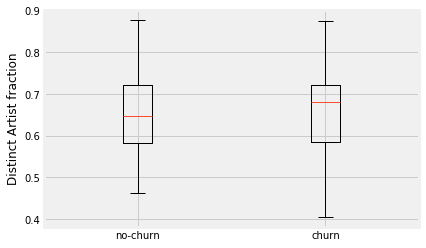

In [59]:
plt.boxplot([artist_song_nc['distinct_artists'].dropna(),artist_song_c['distinct_artists'].dropna()],labels=['no-churn','churn'])
plt.ylabel( 'Distinct Artist fraction')
plt.show()

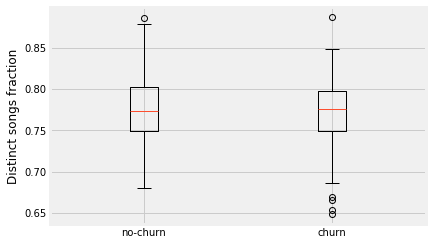

In [60]:
plt.boxplot([artist_song_nc['distinct_songs'].dropna(),artist_song_c['distinct_songs'].dropna()],labels=['no-churn','churn'])
plt.ylabel( 'Distinct songs fraction')
plt.show()

In [61]:
query=""" 
Select userId,count( distinct artist)/count(*) dist_artist_frac ,count( distinct song)/count(*) dist_song_frac
from spotify_cleaned
group by userId
"""
user_artist_song_frac=spark.sql(query)
user_artist_song_frac.show(2)

+------+------------------+------------------+
|userId|  dist_artist_frac|    dist_song_frac|
+------+------------------+------------------+
|200002|0.7598870056497176|0.8305084745762712|
|    51| 0.562322371092164|0.7527405602923264|
+------+------------------+------------------+
only showing top 2 rows



In [62]:
user_artist_song_frac.count()

164

### 6. number of sessions per active days, active days fraction

How many days and how many times a day a user login are important factors to predict the churn. Both these features correlate with activity of the user and active users are less likely to churn. To find the active days fraction, the number of distinct days a user has logged in is determined. This is divided by the difference between minimum and maximum day of a user to get the fraction. To find the sessions per active days, total number of sessions for each user is divided by the number of active days

In [63]:
query=""" 
Select userId,sessions/active_days session_act_days, active_days/duration act_days_frac
from
(Select userId,count(sessionId) sessions, count(distinct date_trunc('day',to_timestamp(ts/1000))) active_days,  datediff(to_date(max(date_trunc('day',to_timestamp(ts/1000)))),to_date(min(date_trunc('day',to_timestamp(ts/1000)))))+1 as duration
from spotify_no_churn
group by userId
order by 4 desc) sub

"""
user_sessions_nc=spark.sql(query).toPandas()

In [64]:
query=""" 
Select userId,sessions/active_days session_act_days, active_days/duration act_days_frac
from
(Select userId,count(sessionId) sessions, count(distinct date_trunc('day',to_timestamp(ts/1000))) active_days,  datediff(to_date(max(date_trunc('day',to_timestamp(ts/1000)))),to_date(min(date_trunc('day',to_timestamp(ts/1000)))))+1 as duration
from spotify_churn
group by userId
order by 4 desc) sub

"""
user_sessions_c=spark.sql(query).toPandas()

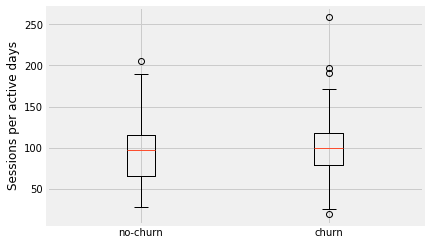

In [65]:
plt.boxplot([user_sessions_c['session_act_days'].dropna(),user_sessions_nc['session_act_days'].dropna()],labels=['no-churn','churn'])
plt.ylabel('Sessions per active days')
plt.show()

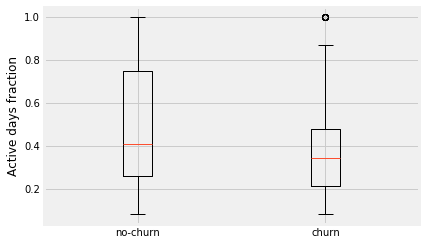

In [66]:
plt.boxplot([user_sessions_c['act_days_frac'].dropna(),user_sessions_nc['act_days_frac'].dropna()],labels=['no-churn','churn'])
plt.ylabel('Active days fraction')
plt.show()

In [67]:
query=""" 
Select userId,sessions/active_days session_act_days, active_days/duration act_days_frac
from
(Select userId,count(sessionId) sessions, count(distinct date_trunc('day',to_timestamp(ts/1000))) active_days,  datediff(to_date(max(date_trunc('day',to_timestamp(ts/1000)))),to_date(min(date_trunc('day',to_timestamp(ts/1000)))))+1 as duration
from spotify_cleaned
group by userId
order by 4 desc) sub

"""
user_sessions=spark.sql(query)
user_sessions.show(5)

+------+------------------+-------------------+
|userId|  session_act_days|      act_days_frac|
+------+------------------+-------------------+
|200023| 101.6470588235294|0.27419354838709675|
|    30| 96.42857142857143|0.11290322580645161|
|   142| 106.0952380952381| 0.3387096774193548|
|   120|102.33333333333333|0.29508196721311475|
|   124|134.02777777777777| 0.5901639344262295|
+------+------------------+-------------------+
only showing top 5 rows



In [68]:
user_sessions.count()

164

###  7. Average items per session

This is roughly proportional to the duration of each session. For each user, average of items in each sessions is determined. Active users might have more items per session

In [69]:
query=""" 
Select userId,avg(items) avg_items_sessions
from
(Select userId,sessionId,count(itemInSession) items
from spotify_no_churn
group by userId,SessionId
order by userId) sub
group by userId
"""
user_items_nc=spark.sql(query).toPandas()

query=""" 
Select userId,avg(items) avg_items_sessions
from
(Select userId,sessionId,count(itemInSession) items
from spotify_churn
group by userId,SessionId
order by userId) sub
group by userId
"""
user_items_c=spark.sql(query).toPandas()

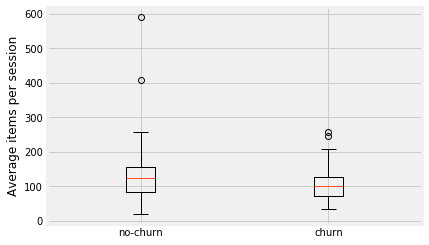

In [70]:
plt.boxplot([user_items_nc['avg_items_sessions'].dropna(),user_items_c['avg_items_sessions'].dropna()],labels=['no-churn','churn'])
plt.ylabel('Average items per session')
plt.show()

In [71]:
query=""" 
Select userId,avg(items) avg_items_sessions
from
(Select userId,sessionId,count(itemInSession) items
from spotify_cleaned
group by userId,SessionId
order by userId) sub
group by userId
"""
user_items=spark.sql(query)
user_items=user_items.fillna(0)
user_items.show(5)

+------+------------------+
|userId|avg_items_sessions|
+------+------------------+
|    10|             132.5|
|   100|100.48275862068965|
|100002|              54.5|
|100004| 61.55555555555556|
|100007|57.666666666666664|
+------+------------------+
only showing top 5 rows



In [72]:
user_items.count()

164

# 8. Gender

In [73]:
# gender counts amount non-churned users
query=""" 
Select gender,count(*) gender_count_entries
from spotify_no_churn
group by gender
"""
spark.sql(query).show()

+------+--------------------+
|gender|gender_count_entries|
+------+--------------------+
|     F|               59857|
|     M|               54581|
+------+--------------------+



In [74]:
# gender counts amount Churned users
query=""" 
Select gender,count(distinct userId) gender_count
from spotify_no_churn
group by gender
"""
spark.sql(query).show()

+------+------------+
|gender|gender_count|
+------+------------+
|     F|          42|
|     M|          46|
+------+------------+



In [75]:
query=""" 
Select gender,count(*) gender_count_entries
from spotify_churn
group by gender
"""
spark.sql(query).show()

+------+--------------------+
|gender|gender_count_entries|
+------+--------------------+
|     F|               65036|
|     M|               42927|
+------+--------------------+



In [76]:
query=""" 
Select gender,count(distinct userId) gender_count
from spotify_churn
group by gender
"""
spark.sql(query).show()

+------+------------+
|gender|gender_count|
+------+------------+
|     F|          37|
|     M|          39|
+------+------------+



In [77]:
query="""
Select userId,Max(gender) as gender
from spotify_cleaned
group by userId
"""
user_gender=spark.sql(query)
user_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|200002|     M|
|   124|     F|
|    51|     M|
|    15|     M|
|    54|     F|
+------+------+
only showing top 5 rows



In [78]:
user_gender.count()

164

In [79]:
# Combine the all the dataframes by the userId column
user_churn_df=user_churn.join(user_gender,user_churn.userId==user_gender.userId).drop(user_churn.userId)
user_churn_df=user_churn_df.join(user_skip_ratio,user_churn_df.userId==user_skip_ratio.userId).drop(user_churn_df.userId)
user_churn_df=user_churn_df.join(user_updown_ratio,user_churn_df.userId==user_updown_ratio.userId,how='full').drop(user_churn_df.userId)
user_churn_df=user_churn_df.join(user_page_count,user_churn_df.userId==user_page_count.userId).drop(user_churn_df.userId)
user_churn_df=user_churn_df.join(user_top10_artist_frac,user_churn_df.userId==user_top10_artist_frac.userId).drop(user_churn_df.userId)
user_churn_df=user_churn_df.join(user_artist_song_frac,user_churn_df.userId==user_artist_song_frac.userId).drop(user_churn_df.userId)
user_churn_df=user_churn_df.join(user_sessions,user_churn_df.userId==user_sessions.userId).drop(user_churn_df.userId)
user_churn_df=user_churn_df.join(user_items,user_churn_df.userId==user_items.userId).drop(user_churn_df.userId)

In [80]:
user_churn_df.count()

163

In [81]:
print(user_churn_df.columns)

['Churn', 'gender', 'skip_ratio', 'updown_ratio', 'Error', 'NextSong', 'Roll Advert', 'top10_frac', 'dist_artist_frac', 'dist_song_frac', 'session_act_days', 'act_days_frac', 'userId', 'avg_items_sessions']


### Create pipeline for transforming the gender variable and creating the vector of features

In [84]:
user_churn_df_train,user_churn_df_test=user_churn_df.randomSplit([.8,.2],seed=125)

In [85]:
print(user_churn_df_train.columns)

['Churn', 'gender', 'skip_ratio', 'updown_ratio', 'Error', 'NextSong', 'Roll Advert', 'top10_frac', 'dist_artist_frac', 'dist_song_frac', 'session_act_days', 'act_days_frac', 'userId', 'avg_items_sessions']


In [86]:
vec_assembler1 = VectorAssembler(inputCols=['skip_ratio','updown_ratio','Error','NextSong',
 'Roll Advert','top10_frac','dist_artist_frac','dist_song_frac','session_act_days','act_days_frac',
                                            'avg_items_sessions'],outputCol='features1')

scaler = StandardScaler(inputCol="features1", outputCol="scaledFeatures",
                        withStd=True, withMean=False)
stringIndexer = StringIndexer(inputCol="gender",outputCol="genderIndex")
encoder = OneHotEncoderEstimator(inputCols=["genderIndex"],outputCols=["genderVec1"])
vec_assembler2 = VectorAssembler(inputCols=["scaledFeatures",'genderVec1'],outputCol='features')
pipeline=Pipeline(stages=[vec_assembler1,scaler,stringIndexer, encoder,vec_assembler2])
model=pipeline.fit(user_churn_df_train)
train=model.transform(user_churn_df_train)
test=model.transform(user_churn_df_test)

# 4. Model Building

**Metrics Selection**

Accuracy is a common choice. In the current dataset,the number of churned users are 76 and non-churned users are 88. As the both classes are nearly equal, accuracy is a good metric. However, if we go to large datasets, classes could be imbalanced. For example, 90% of the users could non-churned and only 10% is churned. In that case, even we incorrectly classify all the churned users, we could get 90% accuracy. So in those cases, precision and recall would be preferred. Precision measures what percentage of predicted postives are actually positive. In our problem, what percentage of predicted churned-users are correct. Recall measures what percentage of churned users are correctly classified ?

In our problem, both precision and recall are equally important. We want to correctly classify most of the churned users and make little error in our predictions. Company might want to send incentives to predicted churned users to keep their subscription and they don't want to send it to regular customers. f1-score seeks a balance between precision and recall and could be a good option in this case. f1 score is defined as

\begin{equation*}
f1-score=\frac{2*(precision*recall)}{(precision+recall)}
\end{equation*}


### Model 1 Logistic Regression

In [87]:
lr = LogisticRegression(labelCol="Churn",featuresCol="features")
lrModel = lr.fit(train)
train_predictions=lrModel.transform(train)
evaluator =evals.MulticlassClassificationEvaluator(labelCol="Churn", predictionCol="prediction",metricName='f1')
print(evaluator.evaluate(train_predictions))
test_predictions=lrModel.transform(test)
print(evaluator.evaluate(test_predictions))

0.6798808588254699
0.6664576802507837


### Model 2 linear SVC

In [88]:
lsvc = LinearSVC(labelCol="Churn",featuresCol="features")
lsvcModel=lsvc.fit(train)
train_predictions=lsvcModel.transform(train)
evaluator =evals.MulticlassClassificationEvaluator(labelCol="Churn", predictionCol="prediction",metricName='f1')
print(evaluator.evaluate(train_predictions))
test_predictions=lsvcModel.transform(test)
print(evaluator.evaluate(test_predictions))

0.6531008945141741
0.7064935064935065


### Model 3 Random Forest

In [89]:
rf = RandomForestClassifier(labelCol="Churn", featuresCol="features", numTrees=25,maxBins=5,maxDepth=4,featureSubsetStrategy='onethird')
rf_model=rf.fit(train)
train_predictions=rf_model.transform(train)
evaluator =evals.MulticlassClassificationEvaluator(labelCol="Churn", predictionCol="prediction",metricName='f1')
print("Train set f1 score is ",evaluator.evaluate(train_predictions))
test_predictions=rf_model.transform(test)
print("Test set f1 score is ",evaluator.evaluate(test_predictions))

Train set f1 score is  0.8416119429121793
Test set f1 score is  0.5454545454545454


### Repeat the models with another split

In [90]:
user_churn_df_train,user_churn_df_test=user_churn_df.randomSplit([.8,.2],seed=180)
vec_assembler1 = VectorAssembler(inputCols=['skip_ratio','updown_ratio','Error','NextSong',
 'Roll Advert','top10_frac','dist_artist_frac','dist_song_frac','session_act_days','act_days_frac',
                                            'avg_items_sessions'],outputCol='features1')

scaler = StandardScaler(inputCol="features1", outputCol="scaledFeatures",
                        withStd=True, withMean=False)
stringIndexer = StringIndexer(inputCol="gender",outputCol="genderIndex")
encoder = OneHotEncoderEstimator(inputCols=["genderIndex"],outputCols=["genderVec1"])
vec_assembler2 = VectorAssembler(inputCols=["scaledFeatures",'genderVec1'],outputCol='features')
pipeline=Pipeline(stages=[vec_assembler1,scaler,stringIndexer, encoder,vec_assembler2])
model=pipeline.fit(user_churn_df_train)
train=model.transform(user_churn_df_train)
test=model.transform(user_churn_df_test)

###  Model 1 Logistic Regression

In [91]:
lr = LogisticRegression(labelCol="Churn",featuresCol="features")
lrModel = lr.fit(train)
train_predictions=lrModel.transform(train)
evaluator =evals.MulticlassClassificationEvaluator(labelCol="Churn", predictionCol="prediction",metricName='f1')
print("Train set f1 score is ",evaluator.evaluate(train_predictions))
test_predictions=lrModel.transform(test)
print("Test set f1 score is ",evaluator.evaluate(test_predictions))

Train set f1 score is  0.7249760765550239
Test set f1 score is  0.5753200204813108


###  Model 2 linear SVC

In [92]:
lsvc = LinearSVC(labelCol="Churn",featuresCol="features")
lsvcModel=lsvc.fit(train)
train_predictions=lsvcModel.transform(train)
evaluator =evals.MulticlassClassificationEvaluator(labelCol="Churn", predictionCol="prediction",metricName='f1')
print("Train set f1 score is ",evaluator.evaluate(train_predictions))
test_predictions=lsvcModel.transform(test)
print("Test set f1 score is ",evaluator.evaluate(test_predictions))

Train set f1 score is  0.7257476912649327
Test set f1 score is  0.5670444638186574


### Model 3 Random Forest

In [93]:
rf = RandomForestClassifier(labelCol="Churn", featuresCol="features", numTrees=25,maxBins=5,maxDepth=4,featureSubsetStrategy='onethird')
rf_model=rf.fit(train)
train_predictions=rf_model.transform(train)
evaluator =evals.MulticlassClassificationEvaluator(labelCol="Churn", predictionCol="prediction",metricName='f1')
print("Train set f1 score is ",evaluator.evaluate(train_predictions))
test_predictions=rf_model.transform(test)
print("Test set f1 score is ",evaluator.evaluate(test_predictions))

Train set f1 score is  0.8689328921054282
Test set f1 score is  0.5753200204813108


# 5. Evaluate the results

Both Logistic Regression and Linear SVC give comparable results While Random Forest overfit. Hoever,results were seen to be affect the split of train and test data. This is expected for smaller dataset where the model does not generalize well.

In the next step, I will attempt to further optimise the Logistic Regression using cross validation and parameter grid search



### Tuning Logistic Regression model

In [94]:
user_churn_df_train,user_churn_df_test=user_churn_df.randomSplit([.8,.2],seed=125)
vec_assembler1 = VectorAssembler(inputCols=['skip_ratio','updown_ratio','Error','NextSong',
 'Roll Advert','top10_frac','dist_artist_frac','dist_song_frac','session_act_days','act_days_frac',
                                            'avg_items_sessions'],outputCol='features1')

scaler = StandardScaler(inputCol="features1", outputCol="scaledFeatures",
                        withStd=True, withMean=False)
stringIndexer = StringIndexer(inputCol="gender",outputCol="genderIndex")
encoder = OneHotEncoderEstimator(inputCols=["genderIndex"],outputCols=["genderVec1"])
vec_assembler2 = VectorAssembler(inputCols=["scaledFeatures",'genderVec1'],outputCol='features')
pipeline=Pipeline(stages=[vec_assembler1,scaler,stringIndexer, encoder,vec_assembler2])
model=pipeline.fit(user_churn_df_train)
train=model.transform(user_churn_df_train)
test=model.transform(user_churn_df_test)

In [96]:
lr = LogisticRegression(labelCol="Churn",featuresCol="features")
evaluator =evals.MulticlassClassificationEvaluator(labelCol="Churn", predictionCol="prediction",metricName='f1')
grid = tune.ParamGridBuilder()
grid = grid.addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0])
grid = grid.addGrid(lr.maxIter,[10, 100, 200])
grid = grid.addGrid(lr.threshold,[.4,.5,.6])
grid = grid.build()
cv = tune.CrossValidator(estimator=lr,
               estimatorParamMaps=grid,
               evaluator=evaluator,numFolds=5)
models = cv.fit(train)
best_lr= models.bestModel

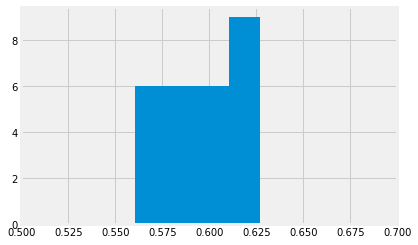

In [124]:
plt.hist(models.avgMetrics,bins=4)
plt.xlim(.50,.70)
plt.show()

In [127]:
best_lr._java_obj.getElasticNetParam()

0.0

In [128]:
best_lr._java_obj.getMaxIter()

100

In [130]:
best_lr._java_obj.getThreshold()

0.6

In [105]:
train_predictions=best_lr.transform(train)
print("Train set f1 score is ",evaluator.evaluate(train_predictions))

Train set f1 score is  0.6818801279376998


In [139]:
test_predictions=best_lr.transform(test)
print("Test set f1 score is ",evaluator.evaluate(test_predictions))

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:57249)
Traceback (most recent call last):
  File "/Users/Vineeth/anaconda3/lib/python3.7/site-packages/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/Vineeth/anaconda3/lib/python3.7/site-packages/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 61] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:57249)

**Test set f1 score is  0.6462891946762914**

This was obtained previously before the connection error. I couldn't rerun the tuning as it did take more than 12 hours.

Unfortunately, tuning didn't improve the performanc on the test data. For the same dataset, performance of the default logistic regression is better than the best model from the tuning

### Evaluate performance on different splits

This step is performed to evaluate the robusteness of the model. I would run the default logistic regression model 5 times with random split and compare the results

In [82]:
def lr_predict(user_churn_df):
    
    """ Split the dataset into train and test. Evaluate a logistic Regression model
    Args
    Input: 
    user_churn_df: dataframe to be evaualted
    Output:
    print the f1-score for train and test data
    """

    user_churn_df_train,user_churn_df_test=user_churn_df.randomSplit([.8,.2])
    vec_assembler1 = VectorAssembler(inputCols=['skip_ratio','updown_ratio','Error','NextSong',
     'Roll Advert','top10_frac','dist_artist_frac','dist_song_frac','session_act_days','act_days_frac',
                                                'avg_items_sessions'],outputCol='features1')

    scaler = StandardScaler(inputCol="features1", outputCol="scaledFeatures",
                            withStd=True, withMean=False)
    stringIndexer = StringIndexer(inputCol="gender",outputCol="genderIndex")
    encoder = OneHotEncoderEstimator(inputCols=["genderIndex"],outputCols=["genderVec1"])
    vec_assembler2 = VectorAssembler(inputCols=["scaledFeatures",'genderVec1'],outputCol='features')
    pipeline=Pipeline(stages=[vec_assembler1,scaler,stringIndexer, encoder,vec_assembler2])
    model=pipeline.fit(user_churn_df_train)
    train=model.transform(user_churn_df_train)
    test=model.transform(user_churn_df_test)

    lr = LogisticRegression(labelCol="Churn",featuresCol="features")
    lrModel = lr.fit(train)
    train_predictions=lrModel.transform(train)
    evaluator =evals.MulticlassClassificationEvaluator(labelCol="Churn", predictionCol="prediction",metricName='f1')
    print(evaluator.evaluate(train_predictions))
    test_predictions=lrModel.transform(test)
    print(evaluator.evaluate(test_predictions))
lr_predict(user_churn_df)

0.7030657342239488
0.7010011123470523


In [83]:
lr_predict(user_churn_df)

0.6861056711190335
0.6537820512820512


In [84]:
lr_predict(user_churn_df)

0.7102422525439408
0.5748251748251748


In [85]:
lr_predict(user_churn_df)

0.6749556635052818
0.7806085043988269


In [86]:
lr_predict(user_churn_df)

0.7589783281733746
0.6066309224203961


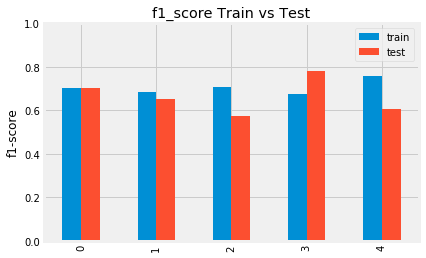

In [112]:
f1_df=pd.DataFrame({'train':train_f1_scores,'test':test_f1_scores})
f1_df.plot.bar()
plt.ylim(0,1)
plt.ylabel('f1-score')
plt.title('f1_score Train vs Test')
plt.show()

Perfomance is slightly dependent on the split. This f1-score on the training set ranged from 0.67 to .75 which is resonably good, while the f1-score for the test set ranged from 0.57 to 0.78. This variation is expected considering that train and test sets has only 131 and 32 samples respectively. I expect the performance to be much better with a large dataset

# Reflection

This was a really interesting project. I had to learn the basics of pyspark first which made it very challenging initially.  So far I have only worked with nicely formatted data with labels and features which can be readily used for building a model. Here I had to label the users first followed by feature engineering.  I really  enjoyed the feature engineering part. This gave me an opportunity to practice the SQL. I was able to implement complex queries to get the features I want. I had to pay lots of attention in cleaning the data as well. Some of the orginal features like level (paid,free) or page(Submit Downgrade) were directly correlated with churned users. If I had included them in my model, I could have obtained a higher value of metrics but a wrong model. 

In the Random Forest Model, I could see how overfitting leads to bad predictions. I could get higher f1-score on the training set but low f1-score on the test set. I also see the limitation of smaller dataset. Depending on the split, my predictions changed. However, I believe, with a larger dataset it will improve.

My model could be further improved by adding extra features. They could be higher order polynomias of the current features or new features like location of users or browsers they used. They would increase the number of features. But I can use dimensionality reduction techniques to avoid overfitting.
